In [51]:
# Import Libraries
#!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading the dataset
This dataset comes from the Kaggle website, and can be found here: <https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers/>

It shows examples of credit card customers with various attributes such as age, activity, credit, etc. 

In [52]:
# Load the dataset
churn_raw = pd.read_csv("churn_data.csv")

In [53]:
len(churn_raw.columns)

23

# Processing the dataset
Firstly, there are some columns within the data that need removed. The last two columns of were published in error as mentioned by the dataset's author and thus are not needed. Additionally, the `CLIENTNUM` field is simply an operational identifier and holds no purpose for the model.

Secondly, the churn column of the dataset needs to be encoded as a numeric value of `0 = Existing Customer` and `1 = Churned Customer`, we'll call this column `Churned`

In [54]:
# Remove last two columns
churn_raw = churn_raw.iloc[:, :-2]

# Remove the CLIENTNUM field
churn_raw.drop("CLIENTNUM", axis=1, inplace=True)

In [55]:
# Encode the Churn Column
encode = {"Existing Customer": 0, "Attrited Customer": 1}
churn_raw["Churned"] = list(map(lambda x: encode[x], churn_raw["Attrition_Flag"]))

# Feature List

| Feature | Description|
|:--------|:-----------|
|CLIENTNUM| Client number. Unique identifier for the customer holding the account|
|Attrition_Flag | Internal event (customer activity) variable - if the account is closed then 1 else 0 |
|Customer_Age | Demographic variable - Customer's Age in Years |
|Gender | Demographic variable - M=Male, F=Female |
|Dependent_count | Demographic variable - Number of dependents |
|Education_Level | Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.) | 
|Marital_Status | Demographic variable - Married, Single, Divorced, Unknown  |
|Income_Category | Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown) |
|Card_Category | Product Variable - Type of Card (Blue, Silver, Gold, Platinum) |
|Months_on_book | Period of relationship with bank |
|Total_Relationship_Count | Total no. of products held by the customer |
|Months_Inactive_12_mon | No. of months inactive in the last 12 months |
|Contacts_Count_12_mon | No. of Contacts in the last 12 months |
|Credit_Limit | Credit Limit on the Credit Card |
|Total_Revolving_Bal | Total Revolving Balance on the Credit Card |
|Avg_Open_To_Buy | Open to Buy Credit Line (Average of last 12 months) |
|Total_Amt_Chng_Q4_Q1 | Change in Transaction Amount (Q4 over Q1) |
|Total_Trans_Amt | Total Transaction Amount (Last 12 months) |
|Total_Trans_Ct | Total Transaction Count (Last 12 months) |
|Total_Ct_Chng_Q4_Q1 | Change in Transaction Count (Q4 over Q1) |
|Avg_Utilization_Ratio | Average Card Utilization Ratio |

In [56]:
# Categorize columns on data type
continuous_features = ["Customer_Age", "Months_on_book", "Credit_Limit", "Total_Revolving_Bal",
                         "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1", "Total_Trans_Amt", "Total_Trans_Ct",
                         "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"]

discrete_features   = ["Dependent_count", "Total_Relationship_Count",
                        "Months_Inactive_12_mon", "Contacts_Count_12_mon"]

nominal_features    = ["Gender", "Marital_Status", "Education_Level", "Card_Category", "Income_Category"]

target              = ["Churned"]

feature_list        = nominal_features + discrete_features + continuous_features + target

churn = churn_raw[feature_list]

# Analyzing the Features
We need to determine which features should be included within our classification model. To do this, we create a Pearson Correlation Matrix between all of the continuous features within the model along with the output target feature. This can show us which features might be redundant or irrelevant.

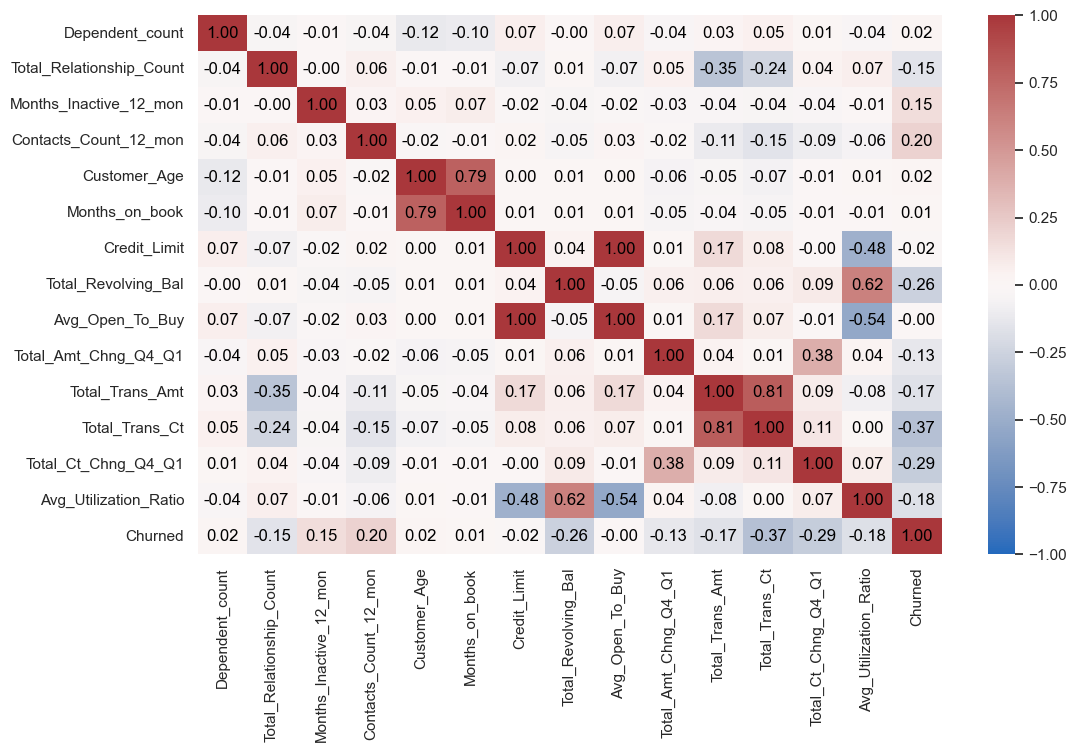

In [57]:
# Create Pearson Correlation Matrix
#!pip install seaborn
import seaborn as sb
corr = churn.corr(numeric_only=True) # Only calculate correlation for numeric fields

# Plot Matrix
sb.set(rc={"figure.figsize":(12, 7)})
ax = sb.heatmap(corr, cmap="vlag", annot=True, fmt='.2f', annot_kws={'color':'black'})
ax.collections[0].set_clim(-1,1)

## Redundant Features
Redundant features are two or more features that are heavily correlate with each other. This means that one feature can be thrown out as any variation in that feature will certainly be captured in the other feature as well. Moreover, one feature even ***should*** be thrown out of the model since including both would weight the combined variation more heavily and skew model performance. Features in this dataset that are redundant
* `Credit_Limit` and `Avg_Open_To_Buy`
  * Correlation: $1$
  * These two are perfectly correlated. This means they are essentially the same feature just twice. This makes sense since they are both just measuring the amount of credit the holder has on the account.
  * We will remove `Avg_Open_To_Buy` and keep `Credit_Limit` to resolve this.
* `Credit_Limit`, `Total_Revolving_Balance`, and `Avg_Utilization_Ratio`
  * Correlation: $-.48$, $.62$, $-.54$
  * These three are all fairly correlated with each other, which also makes sense since Utilization ratio is basically calculated by dividing Revolving Balance by Credit Limit.
  * We will remove `Avg_Utilization_Ratio` and keep the other two.
* `Months_On_Book` and `Customer_Age`
    * Correlation: $.79$
    * These two features being correlated makes sense because how long a customer has been able to have a credit card account depends heavily on how long that customer has been alive.
    * We will remove `Months_On_Book` because `Customer_Age` is slightly more correlated with the output variable as well as could capture more information about the customer in general.
* `Total_Trans_Amt` and `Total_Trans_Ct`
  * Correlation: $.84$
  * It stands to reason that the total amount spent on a credit depends heavily on the number of transactions put onto that card.
  * We will remove `Total_Trans_Amt` since it has a lower correlation with the output variable and therefore is less useful for the model.
    
## Irrelevant Features
Irrelevant Features are features that have almost no, if not completely zero, correlation with the output feature `Churned`. This does not imply that the two features are completely independent from one another. However, it does mean that any changes in the feature itself would provide little to no help in predicting changes in the output variable, from the perspective of a linear model.
* `Avg_Open_To_Buy`
  * Correlation: ~$0$
  * We are already removing `Avg_Open_To_Buy` so we do not have to worry about it.

## Check Feature Variances
### Numeric Features
If any feature were to have an extremely low variance, or for nominal fields if almost all values in the field are the same, this would mean there would be little to know information within the field. Using such a field in a model would provide virtually no benefit to the accuracy of the model as there wouldn't be any change in the field for a model to see a pattern for. They would also hinder the performance of the model as the the model would need to process more data points. These fields can then be removed from the dataset.

In [58]:
from sklearn.preprocessing import normalize
# Select only numeric variables to look at variance
churn_numeric = churn[continuous_features + discrete_features]

# Max Normalize the data in order to accurately compare variances
churn_normalized = pd.DataFrame(normalize(churn_numeric, axis=0, norm="max"))

# Insert Column Names to Normalize Data Frame
churn_normalized.columns = churn_numeric.columns
print(churn_normalized.var())

Customer_Age                0.012060
Months_on_book              0.020339
Credit_Limit                0.069338
Total_Revolving_Bal         0.104842
Avg_Open_To_Buy             0.069367
Total_Amt_Chng_Q4_Q1        0.004164
Total_Trans_Amt             0.033778
Total_Trans_Ct              0.028516
Total_Ct_Chng_Q4_Q1         0.004109
Avg_Utilization_Ratio       0.076158
Dependent_count             0.067487
Total_Relationship_Count    0.067116
Months_Inactive_12_mon      0.028371
Contacts_Count_12_mon       0.033993
dtype: float64


From this analysis we can see that both `Total_Amt_Chng_Q4_Q1` and `Total_Ct_Chng_Q4_Q1` have very low variances ($<1\%$). These fields can be dropped since they are essentially junk and will not be much help in predicting the churn for the model.

### Nominal Features
We can also check the variances, or in this case frequencies, of the nominal features as well. If in a feature an overwhelming majority of values are the same ($>95\%$), then the feature can be dropped since there won't be enough variation in the feature for it to provide meaningful information to the model. This isn't the case for any of the nominal features so they can all be kept. 

In [59]:
# Check nominal features for value frequency
for columnName in nominal_features:
    print(churn[columnName].value_counts(normalize=True))
    print()

Gender
F    0.529081
M    0.470919
Name: proportion, dtype: float64

Marital_Status
Married     0.462822
Single      0.389355
Unknown     0.073961
Divorced    0.073862
Name: proportion, dtype: float64

Education_Level
Graduate         0.308877
High School      0.198776
Unknown          0.149995
Uneducated       0.146835
College          0.100030
Post-Graduate    0.050953
Doctorate        0.044534
Name: proportion, dtype: float64

Card_Category
Blue        0.931767
Silver      0.054804
Gold        0.011455
Platinum    0.001975
Name: proportion, dtype: float64

Income_Category
Less than $40K    0.351634
$40K - $60K       0.176755
$80K - $120K      0.151575
$60K - $80K       0.138442
Unknown           0.109805
$120K +           0.071788
Name: proportion, dtype: float64



# Selecting Features
After analysing the features, we can now remove the ones we do not need in our model and view the resulting correlation matrix

In [60]:
# Removing Unneeded Features
feature_list = nominal_features + discrete_features + continuous_features + target
feature_list.remove("Avg_Open_To_Buy")
feature_list.remove("Months_on_book")
feature_list.remove("Avg_Utilization_Ratio")
feature_list.remove("Total_Amt_Chng_Q4_Q1")
feature_list.remove("Total_Ct_Chng_Q4_Q1")
feature_list.remove("Total_Trans_Amt")

churn = churn_raw[feature_list]

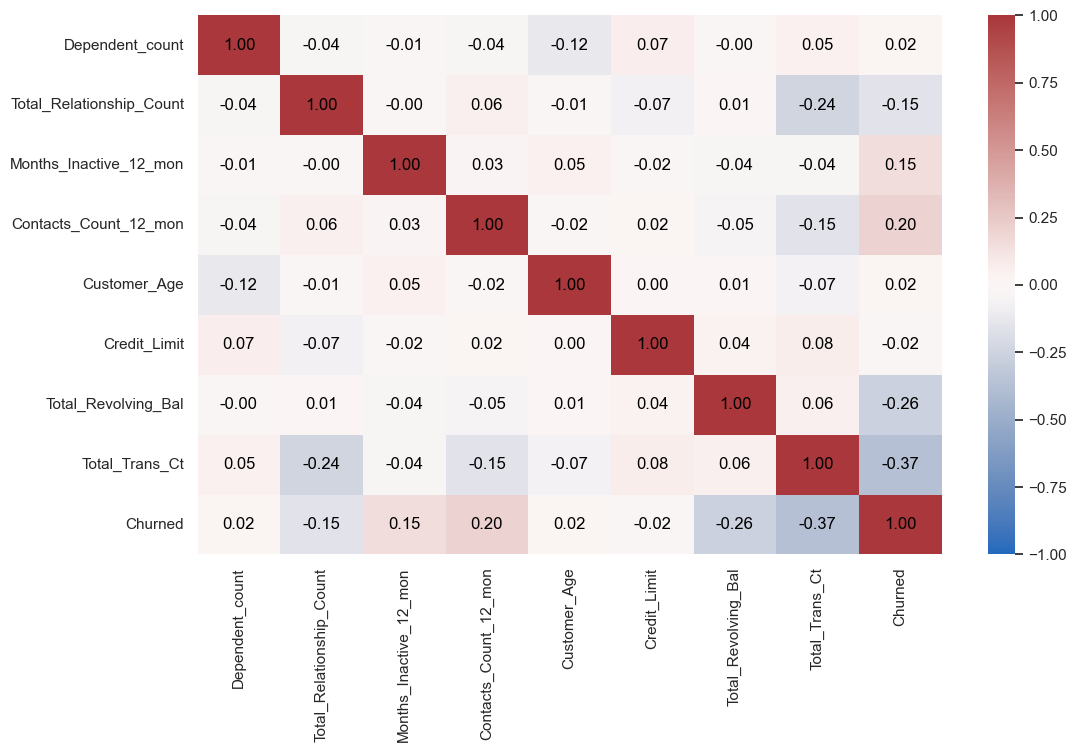

In [61]:
# Create Pearson Correlation Matrix
import seaborn as sb
corr = churn.corr(numeric_only=True) # Only calculate correlation for numeric fields

# Plot Matrix
sb.set(rc={"figure.figsize":(12, 7)})
ax = sb.heatmap(corr, cmap="vlag", annot=True, fmt='.2f', annot_kws={'color':'black'})
ax.collections[0].set_clim(-1,1)

In [62]:
# ANOVA testing of nominal variables
# Importing library
from scipy.stats import f_oneway
 
# Conduct the one-way ANOVA for Gender
print("ANOVA Test P-Value for Gender:\t\t",
      f_oneway(churn_exp["Churned"][churn_exp["Gender"] == 'M'],
               churn_exp["Churned"][churn_exp["Gender"] == 'F']
              ).pvalue
     )

# Conduct the one-way ANOVA for Income_Category
print("ANOVA Test P-Value for Income_Category:\t",
      f_oneway(churn_exp["Churned"][churn_exp["Income_Category"] == "Less than $40K"],
               churn_exp["Churned"][churn_exp["Income_Category"] == "$40K - $60K"],
               churn_exp["Churned"][churn_exp["Income_Category"] == "$80K - $120K"],
               churn_exp["Churned"][churn_exp["Income_Category"] == "$60K - $80K"],
               churn_exp["Churned"][churn_exp["Income_Category"] == "$120K +"]
              ).pvalue
     )

# Conduct the one-way ANOVA for Income_Category
print("ANOVA Test P-Value for Card_Category:\t",
      f_oneway(churn_exp["Churned"][churn_exp["Card_Category"] == "Blue"],
               churn_exp["Churned"][churn_exp["Card_Category"] == "Silver"],
               churn_exp["Churned"][churn_exp["Card_Category"] == "Gold"],
               churn_exp["Churned"][churn_exp["Card_Category"] == "Platinum"]
              ).pvalue
     )

# Conduct the one-way ANOVA for Marital_Status
print("ANOVA Test P-Value for Marital_Status:\t",
      f_oneway(churn_exp["Churned"][churn_exp["Marital_Status"] == "Married"],
               churn_exp["Churned"][churn_exp["Marital_Status"] == "Single"],
               churn_exp["Churned"][churn_exp["Marital_Status"] == "Divorced"]
              ).pvalue
     )

# Conduct the one-way ANOVA for Education_Level
print("ANOVA Test P-Value for Education_Level:\t",
      f_oneway(churn_exp["Churned"][churn_exp["Education_Level"] == "Graduate"],
               churn_exp["Churned"][churn_exp["Education_Level"] == "High School"],
               churn_exp["Churned"][churn_exp["Education_Level"] == "Uneducated"],
               churn_exp["Churned"][churn_exp["Education_Level"] == "College"],
               churn_exp["Churned"][churn_exp["Education_Level"] == "Post-Graduate"],
               churn_exp["Churned"][churn_exp["Education_Level"] == "Doctorate"],
              ).pvalue
     )

ANOVA Test P-Value for Gender:		 0.00017570761823790726
ANOVA Test P-Value for Income_Category:	 0.014794915219504635
ANOVA Test P-Value for Card_Category:	 0.5253408791782983
ANOVA Test P-Value for Marital_Status:	 0.07144883495891485
ANOVA Test P-Value for Education_Level:	 0.038014853512398035


# Feature Engineering

In [63]:
import math
churn_exp = churn.copy()
# Log of Credit Limit
churn_exp.insert(0, "Credit_Limit_Log", np.log(churn["Credit_Limit"]))
# Ordinal Encode Card Category
category_endcode = {"Blue": 0, "Silver": 1, "Gold": 2, "Platinum": 3}
churn_exp.insert(0, "Category_Num", [category_endcode[x] for x in churn["Card_Category"]])
# Ordinal Encode Education
education_endcode = {"Uneducated": 0, "High School": 1, "College": 2, "Graduate": 3, "Post-Graduate": 4, "Doctorate": 5, "Unknown":None}
churn_exp.insert(0, "Education_Num", [education_endcode[x] for x in churn["Education_Level"]])
# Ordinal Encode Income_Category
income_endcode = {"Less than $40K": 0, "$40K - $60K": 40000, "$60K - $80K": 60000, "$80K - $120K": 80000, "$120K +": 120000, "Unknown":None}
churn_exp.insert(0, "Min_Income", [income_endcode[x] for x in churn["Income_Category"]])
# Create Credit_Limit to Income Ratio field
churn_exp.insert(0, "Limit_to_Min_Income_Ratio", churn["Credit_Limit"] / churn_exp["Min_Income"])
# Create Revolving balance to Min Income Ratio field
churn_exp.insert(0, "Balance_to_Min_Income_Ratio", churn["Total_Revolving_Bal"] / churn_exp["Min_Income"])
# Create Dummy Variable for Card Category, Blue or Not Blue
churn_exp.insert(0, "Card_Category_Is_Blue", churn_exp["Card_Category"] == "Blue")
# Discretize Dependent_count field to just Has_Dependents field
churn_exp.insert(0, "Has_Dependents", churn_exp["Dependent_count"] > 0)

# Discretize Dependent_count and Marital_status fields to Married_No_Kids field
churn_exp.insert(0, "Is_Single_With_kids", (churn_exp["Dependent_count"] > 0) *
                                           (churn_exp["Marital_Status"] == "Single")
                )

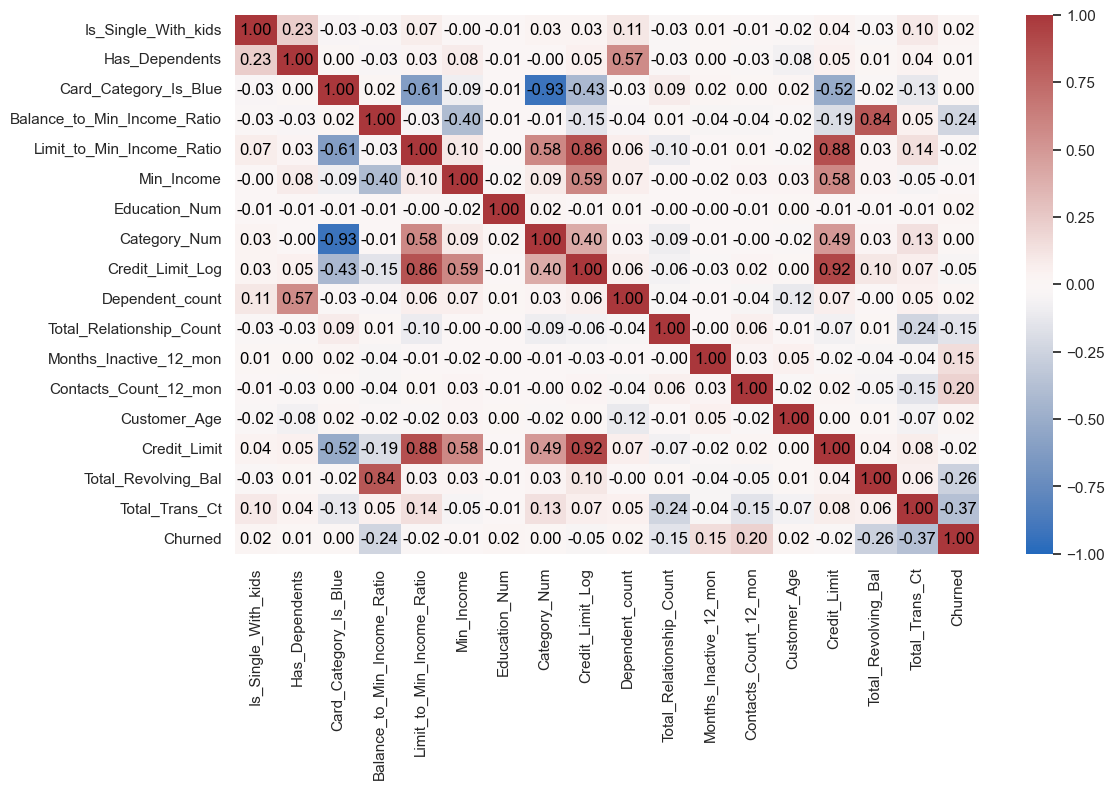

In [64]:
# Create Pearson Correlation Matrix
import seaborn as sb
corr = churn_exp.corr(numeric_only=True) # Only calculate correlation for numeric fields

# Plot Matrix
sb.set(rc={"figure.figsize":(12, 7)})
ax = sb.heatmap(corr, cmap="vlag", annot=True, fmt='.2f', annot_kws={'color':'black'})
ax.collections[0].set_clim(-1,1)

In [65]:
churn_exp.describe()

/Users/ctjenkin/neo4j-project-ej768/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/ctjenkin/neo4j-project-ej768/venv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ctjenkin/neo4j-project-ej768/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/ctjenkin/neo4j-project-ej768/venv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Balance_to_Min_Income_Ratio,Limit_to_Min_Income_Ratio,Min_Income,Education_Num,Category_Num,Credit_Limit_Log,Dependent_count,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Customer_Age,Credit_Limit,Total_Revolving_Bal,Total_Trans_Ct,Churned
count,8116.000000,9015.000000,9015.000000,8608.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,inf,inf,40572.379368,2.061106,0.083638,8.603412,2.346203,3.812580,2.341167,2.455317,46.325960,8631.953698,1162.814061,64.858695,0.160660
std,NaN,NaN,38504.675016,1.412810,0.333784,0.933769,1.298908,1.554408,1.010622,1.106225,8.016814,9088.776650,814.987335,23.472570,0.367235
min,0.000000,0.011986,0.000000,0.000000,0.000000,7.271217,0.000000,1.000000,0.000000,0.000000,26.000000,1438.300000,0.000000,10.000000,0.000000
25%,0.014244,0.098058,0.000000,1.000000,0.000000,7.845808,1.000000,3.000000,2.000000,2.000000,41.000000,2555.000000,359.000000,45.000000,0.000000
50%,0.030050,0.287633,40000.000000,2.000000,0.000000,8.422663,2.000000,4.000000,2.000000,2.000000,46.000000,4549.000000,1276.000000,67.000000,0.000000
75%,NaN,NaN,80000.000000,3.000000,0.000000,9.311768,3.000000,5.000000,3.000000,3.000000,52.000000,11067.500000,1784.000000,81.000000,0.000000
max,inf,inf,120000.000000,5.000000,3.000000,10.449178,5.000000,6.000000,6.000000,6.000000,73.000000,34516.000000,2517.000000,139.000000,1.000000


In [66]:
churn_exp

,Is_Single_With_kids,Has_Dependents,Card_Category_Is_Blue,Balance_to_Min_Income_Ratio,Limit_to_Min_Income_Ratio,Min_Income,Education_Num,Category_Num,Credit_Limit_Log,Gender,...,Income_Category,Dependent_count,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Customer_Age,Credit_Limit,Total_Revolving_Bal,Total_Trans_Ct,Churned
0,False,True,True,0.012950,0.211517,60000.0,1.0,0,9.448648,M,...,$60K - $80K,3,5,1,3,45,12691.0,777,42,0
1,True,True,True,inf,inf,0.0,3.0,0,9.018695,F,...,Less than $40K,5,6,1,2,49,8256.0,864,33,0
2,False,True,True,0.000000,0.042725,80000.0,3.0,0,8.136811,M,...,$80K - $120K,3,4,1,0,51,3418.0,0,20,0
3,False,True,True,inf,inf,0.0,1.0,0,8.105609,F,...,Less than $40K,4,3,4,1,40,3313.0,2517,20,0
4,False,True,True,0.000000,0.078600,60000.0,0.0,0,8.458716,M,...,$60K - $80K,3,5,1,0,40,4716.0,0,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,True,True,True,0.046275,0.100075,40000.0,3.0,0,8.294799,M,...,$40K - $60K,2,3,2,3,50,4003.0,1851,117,0
10123,False,True,True,0.054650,0.106925,40000.0,NaN,0,8.361007,M,...,$40K - $60K,2,4,2,3,41,4277.0,2186,69,1
10124,False,True,True,NaN,inf,0.0,1.0,0,8.595820,F,...,Less than $40K,1,5,3,4,44,5409.0,0,60,1
10125,False,True,True,0.000000,0.132025,40000.0,3.0,0,8.571871,M,...,$40K - $60K,2,4,3,3,30,5281.0,0,62,1


# Finalizing Dataset

In [67]:
# Removing Unneeded Features
feature_list = nominal_features + discrete_features + continuous_features + target
feature_list.remove("Avg_Open_To_Buy")
feature_list.remove("Months_on_book")
feature_list.remove("Avg_Utilization_Ratio")
feature_list.remove("Total_Amt_Chng_Q4_Q1")
feature_list.remove("Total_Ct_Chng_Q4_Q1")
feature_list.remove("Total_Trans_Amt")
feature_list.remove("Card_Category")
feature_list.remove("Marital_Status")

feature_list.remove("Dependent_count")
feature_list.remove("Credit_Limit")
feature_list.remove("Customer_Age")

churn_final = churn_raw[feature_list]

In [68]:
# Discretize Dataset for Models that need Discrete Data

# Customer_Age Credit_Limit Total_Revolving_Bal Total_Trans_Ct 
churn_disc = churn_final.copy()
churn_disc['Total_Revolving_Bal']=pd.cut(x=churn_final['Total_Revolving_Bal'],
                                              bins=[0,359,1276,1784,2517],
                                              #labels =[359,1276,1784,2517],
                                              include_lowest=True
                                             )
churn_disc['Total_Trans_Ct']=pd.cut(x=churn_final['Total_Trans_Ct'],
                                         bins=[10,45,67,81,139],
                                         #labels =[45,67,81,139],
                                         include_lowest=True
                                        )


In [69]:
# Write datasets to csv for models
churn_final.to_csv("data/churn_cleaned.csv", index=False)
churn_disc.to_csv("data/churn_cleaned_discrete.csv", index=False)